In [1]:
import tensorflow as tf
import keras
import keras.backend as K

Using TensorFlow backend.


In [2]:
print (tf.__version__, keras.__version__)

1.12.0 2.2.4


In [3]:
import os
import sys

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

import numpy as np
import random
from random import randint
import pandas as pd
import seaborn as sns
import json

import cv2 as cv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.preprocessing.image import img_to_array
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications.resnet50 import ResNet50
from keras.losses import binary_crossentropy, categorical_crossentropy

from PIL import Image
from glob import glob
from tqdm import tqdm, tqdm_notebook

%pylab inline
%matplotlib inline

sys.path.append('script/')
from metrics import *
from ressources import *
from model import *
from weights_path import *

Populating the interactive namespace from numpy and matplotlib


/root/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['dot', 'average', 'maximum', 'concatenate', 'random', 'multiply', 'copy', 'subtract', 'randint', 'minimum', 'add']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
height, width, channel = 224, 224, 3
batch_size = 32
trainDir = 'TrainingSetImagesDir/'
testDir = 'TestSetImagesDir/'

In [5]:
from keras.applications.nasnet import NASNetMobile, NASNetLarge, preprocess_input
from keras.optimizers import Adam, RMSprop
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet201

In [6]:
df_train = pd.read_csv('TrainingSet_20aimVO.csv')
df_test = pd.read_csv('Mauna_Kea_Supp_Material/test_data_order.csv')

classes = ['Squamous_Epithelium', 'Intestinal_metaplasia', 'Gastric_metaplasia', 'Dysplasia_and_Cancer']

labeled_files = glob('TrainingSetImagesDir/*.png')

labeled_files = [lbl for lbl in labeled_files if  lbl.split(os.path.sep)[-1] in list(df_train.image_filename.values)]
print (len(labeled_files))

id_label_map = {k:v for k, v in zip(df_train.image_filename.values, df_train.class_number.values)}

9446


/root/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


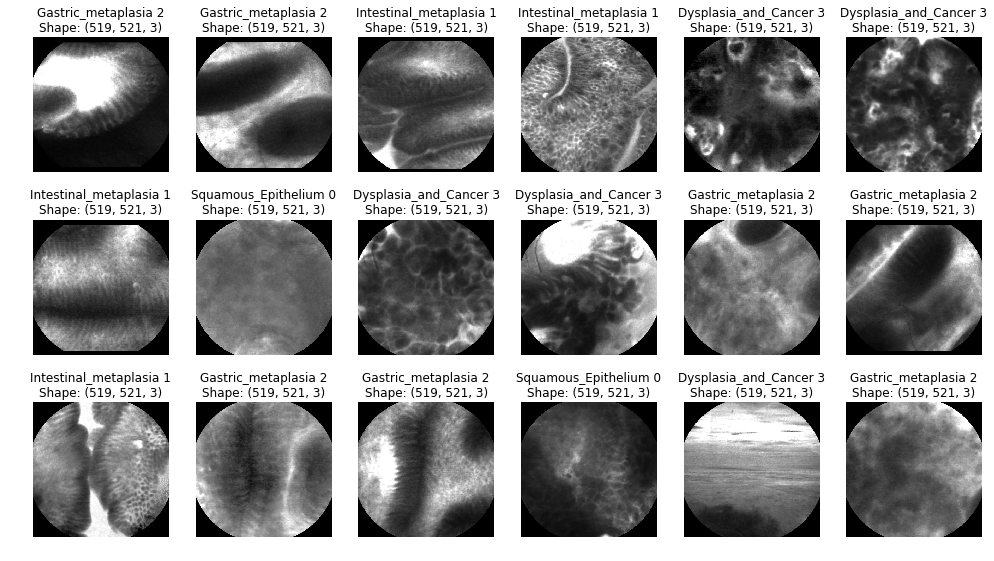

In [7]:
cols = 6
rows = 4

randomLst = []
for i in range(0, (rows * cols)):
    randomLst.append(randint(0, len(labeled_files)))
    
plot_imgs(randomLst, classes, labeled_files, id_label_map, cols=6, rows=3)

In [8]:
ls retrain*

retrain_densenet121.npy          retrain_mobilenet.npy
retrain_densenet169.npy          retrain_nasnet_mobile.npy
retrain_densenet201.npy          retrain_nasnet.npy
retrain_inception_resnet_v2.npy  retrain_resnet50.npy
retrain_inceptionv3.npy          retrain_xception.npy


In [9]:
lstNameNpArray = glob('*retrain*.npy')

In [10]:
print (lstNameNpArray)

['retrain_nasnet.npy', 'retrain_densenet201.npy', 'retrain_inceptionv3.npy', 'retrain_densenet169.npy', 'retrain_densenet121.npy', 'retrain_mobilenet.npy', 'retrain_resnet50.npy', 'retrain_inception_resnet_v2.npy', 'retrain_nasnet_mobile.npy', 'retrain_xception.npy']


In [11]:
lstNameNpArray.remove('retrain_densenet121.npy')
lstNameNpArray.remove('retrain_mobilenet.npy')
lstNameNpArray.remove('retrain_resnet50.npy')
lstNameNpArray.remove('retrain_xception.npy')
lstNameNpArray.remove('retrain_nasnet_mobile.npy')
                      

In [19]:
lstNameNpArray

['retrain_nasnet.npy',
 'retrain_densenet201.npy',
 'retrain_inceptionv3.npy',
 'retrain_densenet169.npy',
 'retrain_inception_resnet_v2.npy']

In [20]:
# weightArray = [1.7, 1.1, 1.1, 1.7, 0.6, 0.5, 0.5, 1.7, 0.5, 1.1]
weightArray = [1.2, 0.9, 0.9, 1.2, 1.2]

In [21]:
np.sum(weightArray)

5.4

In [22]:
lstNpArray = [np.load(n) * w for n, w in zip(lstNameNpArray, weightArray)]

In [23]:
len(lstNpArray)

5

In [24]:
pred_ensemble = np.zeros_like(lstNpArray[0])

for npArray in lstNpArray:
    pred_ensemble = np.add(pred_ensemble, npArray)
pred_ensemble /= np.sum(weightArray)

In [25]:
y_pred_classes = np.argmax(pred_ensemble, axis=1)
y_pred_max_probas = np.max(pred_ensemble, axis=1)

In [26]:
np.argmax(pred_ensemble, axis=1)

array([0, 0, 0, ..., 1, 1, 1])

In [27]:
testImgs = glob('TestSetImagesDir/*/*.png')
df_sub = pd.DataFrame({'image_filename':df_test.image_filename.values, "class_number":['0'] * len(df_test.image_filename.values)})

In [28]:
# test_filenames = [x.split(os.path.sep)[-1] for x in sub_generator.filenames]
df = pd.DataFrame({'image_filename': df_test.image_filename.values})
df['class_number'] = list(y_pred_classes)

In [29]:
df.head()

,image_filename,class_number
0,im_1_16.png,0
1,im_20_16.png,0
2,im_11_16.png,0
3,im_14_16.png,0
4,im_17_16.png,0


In [31]:
name = 'ensemble_w_5'
# df.to_csv('submission/submission_{}.csv'.format(name), index=False)

In [32]:
df.to_csv('submission/submission_{}.csv'.format(name), index=False)
print (name)

ensemble_w_5


check tous les predictions superieur à 40% et leurs nombres

In [33]:
count = 0 
array = np.max(pred_ensemble, axis=1)
maxValues = array > 0.4
for ind, elem in enumerate(maxValues):
    if elem == True:
        count += 1
    else:
        print (ind)  
print (count, len(maxValues))

1066
1714 1715


In [34]:
np.where(pred_ensemble>0.1)

(array([   0,    1,    2, ..., 1713, 1713, 1714]),
 array([0, 0, 0, ..., 1, 2, 1]))

In [35]:
np.argwhere(pred_ensemble>0.1)

array([[   0,    0],
       [   1,    0],
       [   2,    0],
       ...,
       [1713,    1],
       [1713,    2],
       [1714,    1]])

In [36]:
y_pred_max = np.max(pred_ensemble, axis=1)

In [37]:
np.max(pred_ensemble[1290])

0.58501273

In [38]:
pred_ensemble[849]

array([0.00138708, 0.56944263, 0.42800933, 0.00116104], dtype=float32)

In [39]:
pred_ensemble[ np.where( pred_ensemble > 0.44 ) ]

array([0.9999953 , 0.9999978 , 0.9999998 , ..., 0.95544857, 0.8140599 ,
       0.99901676], dtype=float32)

In [40]:
count = 0

Tous les elements superieur a 10% et la difference avec l'element maximum du tableau inferieur a 40%

In [41]:
retrain_index = {}
count = 0
for ind, elem in enumerate(pred_ensemble):
    limit = elem > 0.1
    if len(elem[limit]) > 1:
        sup = elem[limit]
        diff = abs(sup[0] - sup[1])
        if diff < 0.5:
#             print (np.argwhere(limit == True)[:, 0])
#             print (diff)
#             print (elem)
#             print (np.sort((-elem).argsort()[:2]))
            print (elem[(-elem).argsort()[:2]])
#             print (''.join(np.sort((-elem).argsort()[:2]).astype('str')))
#             print ("index: {}".format(ind))
            binary = ''.join(np.sort((-elem).argsort()[:2]).astype('str'))
            if not binary in retrain_index.keys():
                retrain_index[binary] = []
            retrain_index[binary].append(ind)
            count += 1
print (count)

[0.71896166 0.28056002]
[0.5967213 0.4032173]
[0.7103713  0.28941345]
[0.57754046 0.4171325 ]
[0.64555377 0.24639168]
[0.5935491 0.4035905]
[0.6239256  0.27867463]
[0.53676164 0.46323726]
[0.7043912 0.2956062]
[0.67111635 0.32888162]
[0.6815207 0.3184719]
[0.71993995 0.2800544 ]
[0.5329352 0.4670532]
[0.6957456  0.30419043]
[0.6415735  0.35842556]
[0.55731475 0.44268388]
[0.6654854 0.3345122]
[0.66224766 0.33774498]
[0.5531652 0.4468242]
[0.69004226 0.30992857]
[0.54351    0.45647842]
[0.55993986 0.4400383 ]
[0.5191638  0.48001018]
[0.5481682 0.426749 ]
[0.64070874 0.27302667]
[0.6360518 0.3628491]
[0.520048   0.42484567]
[0.7383204  0.25755677]
[0.5672165  0.31626618]
[0.5441515  0.23410015]
[0.6033059  0.39334252]
[0.4501073  0.43769634]
[0.49092576 0.28955084]
[0.50659066 0.3959513 ]
[0.42512   0.4130195]
[0.72192436 0.27080274]
[0.6185151  0.29875273]
[0.6310198 0.2518597]
[0.69738895 0.2965935 ]
[0.55412465 0.39229825]
[0.593622   0.38175035]
[0.6245192  0.34442028]
[0.68527246 0.

In [43]:
classes =  ['01', '23', '13', '12', '03', '02']
names = ['resnet_binary_01_weights.05-0.02-0.99-0.01-1.00.hdf5',
          'resnet_binary23_weights.07-0.03-0.99-0.01-1.00.hdf5',
          'resnet_binary13_weights.12-0.02-0.99-0.00-1.00.hdf5',
          'resnet_binary12_weights.07-0.04-0.99-0.04-0.99.hdf5',
          'resnet_binary03_weights.04-0.04-0.99-0.02-1.00.hdf5',
          'resnet_binary02_weights.04-0.05-0.98-0.01-1.00.hdf5']
res_binary_dict = {k: v for k, v in zip(classes, names)}

In [44]:
datagen = ImageDataGenerator(
            rescale=1./255, 
        )

In [45]:
K.clear_session()
weights = resnet50_path
#     weights = 'model2/{}'.format(res_binary_dict[k])
pretrained_model = ResNet50(weights=weights, include_top=False)
model = get_model_1(pretrained_model, 2, 0, binary_crossentropy)

/root/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [46]:
predict_binary = []
for k, v in retrain_index.items():
    df_sub = pd.DataFrame({'image_filename':df_test.loc[retrain_index[k]].image_filename.values, "class_number":['0'] * len(retrain_index[k])})
    model.load_weights('model2/{}'.format(res_binary_dict[k]))
    print ("{} loaded".format(res_binary_dict[k]))
    generator = datagen.flow_from_dataframe(directory='test',
                                            dataframe=df_sub,
                                            x_col="image_filename",
                                            y_col="class_number",
                                            class_mode='categorical',
                                            target_size=(height, width),
                                            batch_size=1,
                                            shuffle=False,
                                            pickle_safe = True,
                                            workers = 1,
                                            seed=42)
    predict_binary.append(model.predict_generator(generator,
                                          steps=(len(generator.filenames)),
                                          verbose=1))

resnet_binary12_weights.07-0.04-0.99-0.04-0.99.hdf5 loaded
Found 80 validated image filenames belonging to 1 classes.
80/80 [==============================] - 3s 31ms/step
resnet_binary23_weights.07-0.03-0.99-0.01-1.00.hdf5 loaded
Found 15 validated image filenames belonging to 1 classes.
15/15 [==============================] - 0s 12ms/step
resnet_binary13_weights.12-0.02-0.99-0.00-1.00.hdf5 loaded
Found 30 validated image filenames belonging to 1 classes.
30/30 [==============================] - 0s 12ms/step
resnet_binary_01_weights.05-0.02-0.99-0.01-1.00.hdf5 loaded
Found 27 validated image filenames belonging to 1 classes.
27/27 [==============================] - 0s 11ms/step
resnet_binary03_weights.04-0.04-0.99-0.02-1.00.hdf5 loaded
Found 30 validated image filenames belonging to 1 classes.
30/30 [==============================] - 0s 11ms/step
resnet_binary02_weights.04-0.05-0.98-0.01-1.00.hdf5 loaded
Found 14 validated image filenames belonging to 1 classes.
14/14 [==============

In [47]:
y_pred_classes = np.argmax(pred_ensemble, axis=1)
y_pred_max_probas = np.max(pred_ensemble, axis=1)

si mauvaise resultat mettre un differenciel pour rendre le model plus robuste

In [48]:
count = 0
for (k, v), predict in zip(retrain_index.items(), predict_binary):
    clsName = list(k)
    for val, pred in zip(v, predict):
        print (val, clsName[np.argmax(pred)])
        
        if str(y_pred_classes[val]) != clsName[np.argmax(pred)]:
            print (pred)
            print (pred_ensemble[val])
            print ('index {} changed from {} to {}'.format(val, y_pred_classes[val], clsName[np.argmax(pred)]))
            count += 1
        y_pred_classes[val] = clsName[np.argmax(pred)]
print ('number of elem changed {}'.format(count))

132 2
133 2
134 2
170 2
195 1
[0.9253587  0.07464129]
[0.0048577  0.24639168 0.64555377 0.10319684]
index 195 changed from 2 to 1
715 1
819 2
[0.10910255 0.8908974 ]
[0.05183203 0.50948226 0.43449104 0.00419465]
index 819 changed from 1 to 2
820 2
[0.42973545 0.5702645 ]
[0.02355885 0.45690998 0.4541457  0.06538542]
index 820 changed from 1 to 2
824 1
828 2
[0.1207224 0.8792776]
[0.00268967 0.6653119  0.29856104 0.03343745]
index 828 changed from 1 to 2
844 2
845 2
[0.37492672 0.62507325]
[1.2023413e-04 5.9355879e-01 4.0457794e-01 1.7431027e-03]
index 845 changed from 1 to 2
846 2
849 1
855 2
[0.4318382 0.5681618]
[3.0662308e-05 7.3456377e-01 2.6533732e-01 6.8279776e-05]
index 855 changed from 1 to 2
867 2
871 2
[0.4996698 0.5003302]
[0.00242131 0.6181488  0.37571055 0.00371931]
index 871 changed from 1 to 2
1010 2
1031 2
1032 1
1034 1
[0.8956678  0.10433217]
[1.5098328e-04 4.6594998e-01 5.3366905e-01 2.2997578e-04]
index 1034 changed from 2 to 1
1035 1
1038 1
[0.5707114 0.4292886]
[3.

In [96]:
df = pd.DataFrame({'image_filename': df_test.image_filename.values})
df['class_number'] = list(y_pred_classes)

name = 'ensemble_w_10_binary'
df.to_csv('submission/submission_{}.csv'.format(name), index=False)
print ('{} created'.format(name))

ensemble_w_10_binary created


In [97]:
len(df_test.image_filename)

1715